In [40]:
!python3 --version

Python 3.7.3


In [56]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
data_raw = pd.read_csv('dataset/sign_mnist_train.csv', sep=",")

labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)

data, labels = data_raw.values, labels.values

In [ ]:
IMAGE_SIZE = 28

In [100]:
def num_to_letter(num: int) -> str:
    start = ord('a')
    return chr(num + start)

examples = [num_to_letter(i) for i in range(26)]
print(examples)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [99]:
test_data_raw = pd.read_csv('dataset/sign_mnist_test.csv', sep=",")

labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

test_data, labels_test = test_data_raw.values, labels_test.values

In [110]:
from ipywidgets import interact

@interact(i = (0, len(data)))
def show_image_dataset(i):
    info, label = data[i], labels[i]
    pixels = info.reshape(IMAGE_SIZE, IMAGE_SIZE)

    _, ax = plt.subplots(figsize=(3.5, 3.5))
    sns.heatmap(data=pixels, cmap="YlGnBu", ax=ax)
    plt.title(num_to_letter(label), fontsize=30, color="#00008b")
    
    plt.show()

interactive(children=(IntSlider(value=13727, description='i', max=27455), Output()), _dom_classes=('widget-int…

In [111]:
data = [pic.reshape(1, IMAGE_SIZE, IMAGE_SIZE) for pic in data]
test_data = [pic.reshape(1, IMAGE_SIZE, IMAGE_SIZE) for pic in test_data]

x = torch.FloatTensor(data)
y = torch.LongTensor(labels.tolist())

test_data_formated = torch.FloatTensor(test_data)
test_labels       = torch.LongTensor(labels_test.tolist())

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [49]:
train_on_gpu = torch.cuda.is_available()
print(f"train_on_gpu = {train_on_gpu}")

train_on_gpu = False


In [114]:
epochs = 10
batch_size = 64
learning_rate = 0.0012

In [155]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3    = nn.Conv2d(20, 30, 3) 
        self.dropout1 = nn.Dropout2d()
        
        self.fc3 = nn.Linear(30 * 3 * 3, 256) 
        self.fc4 = nn.Linear(256, 26)
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = x.view(-1, self.fc3.in_features) 

        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    
    
    def test(self, predictions, labels):
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        accuracy = correct / len(predictions)
        print(f"Correct predictions: {correct} / {len(predictions)}: ", end="")
        print(f"{round(accuracy, 6)}")

    
    def evaluate(self, predictions, labels):  
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        accuracy = correct / len(predictions)
        return accuracy

In [154]:
net = Network()
print(net)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=270, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=26, bias=True)
  (softmax): LogSoftmax()
)


In [153]:
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

In [157]:
loss_log = []
accuracy_log = []

for epoch in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_minibatch = Variable(x[i : i + batch_size])
        y_minibatch = Variable(y[i : i + batch_size])
        
        optimizer.zero_grad()
        net_out = net(x_minibatch)
        loss = loss_func(net_out, y_minibatch)
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            loss_log.append(loss.item())
            test_sample = Variable(test_data_formated[:500])
            current_accuracy = net.evaluate(torch.max(net(test_sample).data, 1)[1], test_labels[:500])
            accuracy_log.append(current_accuracy)
        
    print(f"Epoch: {epoch + 1} - Loss: {round(loss.item(), 6)}")

Epoch: 1 - Loss: 3.973656
Epoch: 2 - Loss: 3.884887
Epoch: 3 - Loss: 3.902095
Epoch: 4 - Loss: 4.259124
Epoch: 5 - Loss: 3.998062
Epoch: 6 - Loss: 4.08281
Epoch: 7 - Loss: 3.944262
Epoch: 8 - Loss: 3.925421
Epoch: 9 - Loss: 4.093451


KeyboardInterrupt: 

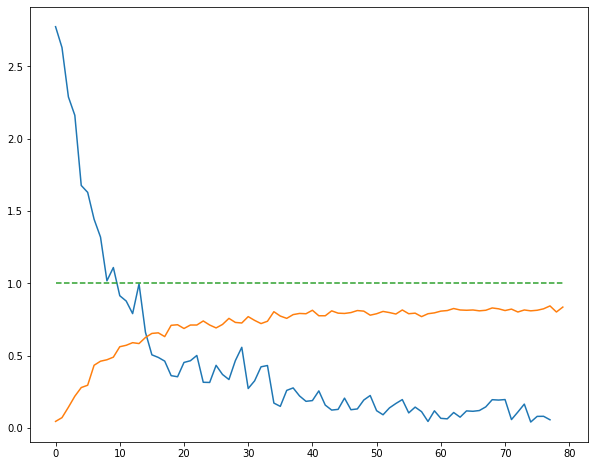

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')

In [158]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        optimizer.zero_grad()
        net_out = net(Variable(x_mini))
        
        loss = loss_func(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(net.evaluate(torch.max(net(Variable(test_data_formated[:500])).data, 1)[1], 
                                        test_labels[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 3.940668
Epoch: 2 - Loss: 3.925491
Epoch: 3 - Loss: 4.087933
Epoch: 4 - Loss: 4.072876
Epoch: 5 - Loss: 4.143585
Epoch: 6 - Loss: 3.992176
Epoch: 7 - Loss: 3.920360
Epoch: 8 - Loss: 4.140103
Epoch: 9 - Loss: 3.954875
Epoch: 10 - Loss: 3.956251
Epoch: 11 - Loss: 3.972302
Epoch: 12 - Loss: 3.863096
Epoch: 13 - Loss: 3.896891
Epoch: 14 - Loss: 4.070690
Epoch: 15 - Loss: 3.960777
Epoch: 16 - Loss: 4.008316
Epoch: 17 - Loss: 4.024144
Epoch: 18 - Loss: 4.116922
Epoch: 19 - Loss: 3.958511
Epoch: 20 - Loss: 4.148710


In [141]:



@interact(sample = (0, len(test_data)))
def show_image_dataset(sample):
    info, label = test_data[sample], labels_test[sample]
    pixels = info.reshape(IMAGE_SIZE, IMAGE_SIZE)

    test_sample = torch.FloatTensor([info.reshape(1, 28, 28).tolist()])
    test_var_sample = Variable(test_sample)
    net_out_sample = net(test_var_sample)
    predicted_label = torch.max(net_out_sample.data, 1)[1].numpy()[0]

    _, ax = plt.subplots(figsize=(3.5, 3.5))
    sns.heatmap(data=pixels, cmap="YlGnBu", ax=ax)

    actual    = f"{num_to_letter(label)} ⟵ actual"
    predicted = f"{num_to_letter(predicted_label)} ⟵ predicted"
    plt.title(actual + "\n" + predicted, fontsize=20, color="#00008b", loc="left")

    plt.show()

interactive(children=(IntSlider(value=3586, description='sample', max=7172), Output()), _dom_classes=('widget-…

In [147]:
predictions = net(Variable(test_data_formated))
net.test(torch.max(predictions.data, 1)[1], test_labels)

Correct predictions:  6579 /  7172:     0
